In [24]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import string
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [62]:
df = pd.read_csv('memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['image_name','text_ocr', 'humour', 'sarcasm', 'offensive', 'motivational'])
df.head()

,text_corrected,overall_sentiment
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,positive
1,The best of #10 YearChallenge! Completed in le...,positive
2,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,10 Year Challenge - Sweet Dee Edition,positive
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [63]:
meme_text = pd.DataFrame()
meme_text['text'] = df.text_corrected
meme_text['sentiment'] = df.overall_sentiment
meme_text.head()

,text,sentiment
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,positive
1,The best of #10 YearChallenge! Completed in le...,positive
2,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,10 Year Challenge - Sweet Dee Edition,positive
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [64]:
cleaned = meme_text.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

text         False
sentiment    False
dtype: bool

In [65]:
target = cleaned['sentiment']
target = pd.get_dummies(target)
labels = []
for _, i in target.iterrows():
    labels.append(np.argmax(i))
labels[0:5]

[2, 2, 2, 2, 1]

In [66]:
import nlpaug
import nlpaug.augmenter.word as naw
def Augmentation(text, labels):
    aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)
    augmented_sentences = []
    augmented_sentences_labels = []
    for i in range(0, len(text)):
        if np.argmax(labels.iloc[i]) == 0:
            t = 0
            temps = aug.augment(text.iloc[i],n=6)
        elif np.argmax(labels.iloc[i]) == 1:
            t = 1
            temps = aug.augment(text.iloc[i],n=2)
        else:
            augmented_sentences.append(text.iloc[i])
            augmented_sentences_labels.append(2)
            continue
        for sent in temps:
            augmented_sentences.append(sent)
            augmented_sentences_labels.append(t)
        
    return augmented_sentences,augmented_sentences_labels

In [67]:
text, sent = Augmentation(cleaned.text, target)
cleaned = pd.DataFrame()
cleaned['text'] = text
cleaned['sentiment'] = sent

In [68]:
from tensorflow.keras.utils import to_categorical
sent = to_categorical(sent)
pd.DataFrame(text).shape, pd.DataFrame(sent).shape

((12342, 1), (12342, 3))

In [69]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [70]:
def remove_stopwords(data):
    data['text'] = data['text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
    return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
 
data_without_stopwords = []
data_without_stopwords = remove_stopwords(cleaned)
data_without_stopwords['text']= data_without_stopwords['text'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['text'] = data_without_stopwords['text'].str.replace('[{}]'.format(string.punctuation), ' ')

In [71]:
text = data_without_stopwords.text
sentiment = data_without_stopwords['sentiment']

In [73]:
cleaned['token_size'] = text.apply(lambda x: len(x.split(' ')))
data = cleaned.loc[cleaned['token_size']]
#data = data.sample(n= 50000)

In [74]:
# Construct a vocabulary
class ConstructVocab():
    
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for sent in self.sentences:
            self.vocab.update(sent.split(' '))
        
        #sort vacabulary
        self.vocab = sorted(self.vocab)
        
        #add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        #word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # 0 is the pad
            
        #index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word
inputs = ConstructVocab(data['text'].values.tolist())

In [75]:
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')] for es in data['text']]

In [76]:
def max_length(tensor):
    return max(len(t) for t in tensor)
max_length_input = max_length(input_tensor)
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
        
    return padded
input_tensor = [pad_sequences(x, max_length_input) for x in input_tensor]

In [77]:
y = sent
pd.DataFrame(y).head()

,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [81]:
X_train, X_test,Y_train, Y_test = train_test_split(input_tensor, y, test_size=0.3, random_state = 45)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.4)
np.array(X_train).shape, np.array(X_test).shape, np.array(X_val).shape

((8639, 54), (2221, 54), (1482, 54))

In [89]:
embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
#target_size = len(target[0])

In [99]:
from keras.layers.embeddings import Embedding
from keras.layers import GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
def create_model():
    model = Sequential()
    model.add(Embedding(vocab_inp_size, embedding_dim, input_length=max_length_input))
    model.add(Dropout(0.5))
    model.add(GRU(units))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

In [100]:
model = create_model()
model.build((None, max_features))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_25 (ModuleWra (None, 13000, 256)        130304    
_________________________________________________________________
module_wrapper_26 (ModuleWra (None, 13000, 256)        0         
_________________________________________________________________
module_wrapper_27 (ModuleWra (None, 1024)              3938304   
_________________________________________________________________
module_wrapper_28 (ModuleWra (None, 3)                 3075      
Total params: 4,071,683
Trainable params: 4,071,683
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = model.fit(pd.DataFrame(X_train), Y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(pd.DataFrame(X_val), Y_val),
                    batch_size=64)

Epoch 1/10
135/135 [==============================] - 13s 59ms/step - loss: 1.1002 - accuracy: 0.3447 - val_loss: 1.0977 - val_accuracy: 0.3252
Epoch 2/10
135/135 [==============================] - 8s 57ms/step - loss: 1.1000 - accuracy: 0.3504 - val_loss: 1.0951 - val_accuracy: 0.3812
Epoch 3/10
135/135 [==============================] - 8s 57ms/step - loss: 1.0987 - accuracy: 0.3432 - val_loss: 1.0969 - val_accuracy: 0.3252
Epoch 4/10
135/135 [==============================] - 8s 57ms/step - loss: 1.0990 - accuracy: 0.3498 - val_loss: 1.0939 - val_accuracy: 0.3806
Epoch 5/10
135/135 [==============================] - 8s 58ms/step - loss: 1.0937 - accuracy: 0.3635 - val_loss: 1.0947 - val_accuracy: 0.3246
Epoch 6/10
135/135 [==============================] - 8s 58ms/step - loss: 1.0922 - accuracy: 0.3672 - val_loss: 1.0995 - val_accuracy: 0.3293
Epoch 7/10
135/135 [==============================] - 8s 58ms/step - loss: 1.0924 - accuracy: 0.3635 - val_loss: 1.1157 - val_accuracy: 0.325

In [102]:
ypred = model.predict(pd.DataFrame(X_test))

In [103]:
ypred = np.argmax(ypred, axis = 1)
y_test = np.argmax(np.array(Y_test), axis = 1)

Text(33.0, 0.5, 'Truth')

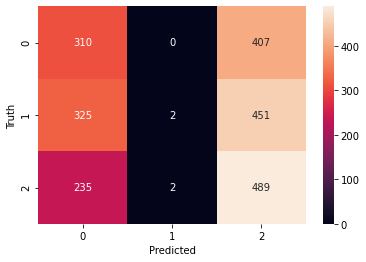

In [104]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, ypred)
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [105]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.36      0.43      0.39       717
           1       0.50      0.00      0.01       778
           2       0.36      0.67      0.47       726

    accuracy                           0.36      2221
   macro avg       0.41      0.37      0.29      2221
weighted avg       0.41      0.36      0.28      2221

